In [17]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import scipy.signal as ss
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression # must come before nest

from generate_triple_data import par, simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
import statsmodels.api as sm
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import pandas as pd
%matplotlib inline

In [33]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

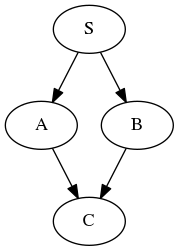

In [3]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S'])
G.add_edges_from([('A','C'), ('B', 'C'), ('S', 'A'), ('S', 'B')])
draw(G, show='ipynb')

In [4]:
def raised_cosine(n_bases, bin_size, end_peak_times, offset, stretching='log'):
    '''Raised cosine basis
      ^
     / \
    /   \______
         ^
        / \
    ___/   \___
            ^
           / \
    ______/   \
    Make log or linearly stretched basis consisting of raised cosines.
    Log stretching allows faster changes near the event.
    
    Parameters
    ----------
    n_bases : int
        Number of basis vectors
    bin_size : float
        time bin size (separation for representing basis
    end_peak_times : array
        [2 x 1] array containg [1st_peak,  last_peak], the peak
             (i.e. center) of the first and the last raised cosine basis vectors
    offset: float
        offset for log stretching of x axis:  y = log(t + offset)
        (larger offset -> more nearly linear stretching)
    stretching : str
        "log" or "linear"

    Returns
    -------
    time : array
        time lattice on which basis is defined
    bases : array
        basis itself
    centers : array
        centers of each basis function

    Example
    -------
    time, bases, centers = log_raised_cosine(10, 1, [0, 500], 2);
    '''
    if stretching == 'log':
        if offset <= 0:
            raise ValueError('offset must be greater than 0')
        #log stretching x axis (and its inverse)
        stretch = lambda x: np.log(x + 1e-20)
        inv_stretch = lambda x: np.exp(x) - 1e-20
    elif stretching == 'linear':
        stretch = lambda x: x
        inv_stretch = lambda x: x
        offset = 0
    else:
        raise ValueError('stretching must be "log" or "linear"')
    
    x_range = stretch(end_peak_times + offset)

    db = np.diff(x_range) / (n_bases - 1)  # spacing between raised cosine peaks

    centers = np.arange(x_range[0], x_range[1] + db / 2, db)  # centers for basis vectors

    max_time_bin = inv_stretch(x_range[1] + db) - offset  # maximum time bin (originally 2 * db)

    time = np.arange(0, max_time_bin, bin_size)
    
    centers_tiled = np.tile(centers, (time.size, 1))

    time_stretch_tiled = np.tile(stretch(time + offset)[:, np.newaxis], (1, n_bases))

    def _raised_cosine(time, centers, dc):
        center_adjusted = (time - centers) * np.pi / dc # originally divided by 2
        center_adjusted_min = np.minimum(np.pi, center_adjusted)
        center_adjusted_min_max = np.maximum(-np.pi, center_adjusted_min)
        return (np.cos(center_adjusted_min_max) + 1) / 2

    bases = _raised_cosine(time_stretch_tiled, centers_tiled, db)

    centers = inv_stretch(centers)

    return time, bases, centers

In [5]:
def xcorr(t1, t2, binsize=1e-3, limit=[-1, 1], density=False):
    '''
    Cross correlation histogram (CCH) of t1 vs t2
    '''
    if isinstance(limit, (int, float)):
        limit = [-limit, limit]
    bins = np.arange(limit[0], limit[1] + binsize, binsize)
    ii2 = np.searchsorted(t2, t1 + limit[0])
    jj2 = np.searchsorted(t2, t1 + limit[1])
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])
    count, bins = np.histogram(big, bins=bins, density=density)
    
    return bins[1:], count


def fit_latency(pre, post, binsize=.1e-3, limit=[-10e-3, 20e-3], init=[5e-4, 5e-4], plot=False):
    '''
    Fit a gaussian PDF to density of CCH
    '''
    b, c = xcorr(pre, post, binsize=binsize, limit=limit, density=True)
    normpdf  = lambda p, x: st.norm.pdf(x, *p)
    error  = lambda p, x, y: (y - normpdf(p, x))
    res, _ = leastsq(error, init, args=(b, c))
    if plot:
        plt.bar(b, c, width=-binsize, align='edge')
        y = normpdf(res, b)
        plt.plot(b, y, 'r--', linewidth=2)
        plt.title('$\Delta t$ {:.3f} $\sigma$ {:.3f}'.format(*res))
#         plt.axvspan(delta_t - sigma, delta_t + sigma, alpha=.5, color='cyan')
    return res

In [62]:
def calculate_regressors(x, y, stim_times, latency, winsize):
    stim_times = stim_times.astype(float)
    
    src_x = np.searchsorted(x, stim_times, side='right')
    
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    Z = x[src_x-1] - stim_times
    X = x[src_x] - stim_times
    
    stim_win = np.insert(
        stim_times + latency, 
        np.arange(len(stim_times)) + 1, 
        stim_times + latency + winsize)
    src_y = np.searchsorted(y, stim_win, side='left')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    return Z, X, Y


# def IV(x, y, stim_times, latency, winsize):
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
#     X = ((X > 0.001) & (X < 0.003)).astype(int)
#     Z = Z.reshape(-1, 1)
    
#     model = LogisticRegression(C=1e5, solver='liblinear')

#     model.fit(Z, X)
#     X_hat = model.predict(Z)
    
#     X_hat = np.vstack((X_hat, np.ones(X_hat.shape[0]))).T
#     beta_IV, _ = np.linalg.lstsq(X_hat, Y, rcond=None)[0]
    
#     return beta_IV


def IV(x, y, stim_times, latency, winsize):
            
    Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
    X = ((X > 0.001) & (X < 0.003)).astype(int)
    Z = np.abs(Z)
    
    
    n_bases = 20
    bin_size = 1e-3
    max_time = Z.max()
    offset = .01
    
    time, bases, centers = raised_cosine(n_bases, bin_size, np.array([0, max_time]), offset)
    Z_bases = np.zeros((len(Z), n_bases))

    def index(t, bin_size):
        return np.ceil(t / bin_size).astype(int)

    idxs = index(Z, bin_size)

    for i, j in enumerate(idxs):
        Z_bases[i, :] = bases[j, :]
    

    model = LogisticRegression(C=1e5, solver='liblinear')
    model.fit(Z_bases, X)
    X_hat = model.predict(Z_bases)
    
    X_hat = np.vstack((X_hat, np.ones(X_hat.shape[0]))).T
    beta_IV, _ = np.linalg.lstsq(X_hat, Y, rcond=None)[0]
    
    return beta_IV

(0.15609272576485714, -0.012625232288856977)

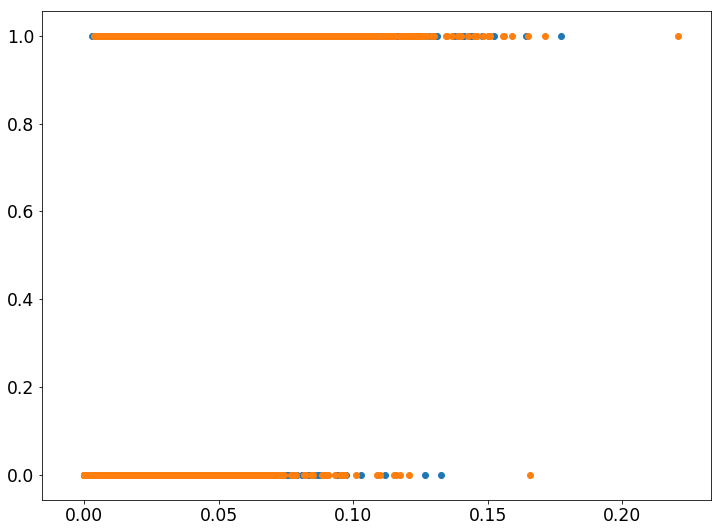

In [58]:
t = 500
latency = 4e-3
winsize = 4e-3

mask_A = (A_spikes < t)
mask_B = (B_spikes < t)
mask_C = (C_spikes < t)
mask_S = (stim_times < t)

beta_AC = IV(A_spikes[mask_A], C_spikes[mask_C], stim_times[mask_S], latency, winsize)

beta_BC = IV(B_spikes[mask_B], C_spikes[mask_C], stim_times[mask_S], latency, winsize)
beta_AC, beta_BC

In [63]:
amps = np.arange(0, 3.1, .1)
simulations = defaultdict(list)
for a in amps:
    data = simulate(par, stop_time=600, J_AC=a, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)
    stop_time = data['status']['time']
    A_spikes, B_spikes, C_spikes = [s['times'] for s in data['spiketrains']]
    
    stim_times = data['epoch']['times']
    
    simulations['stim_times'].append(stim_times)
    simulations['A_spikes'].append(A_spikes)
    simulations['B_spikes'].append(B_spikes)
    simulations['C_spikes'].append(C_spikes)
    simulations['stop_time'].append(stop_time)

simulating  599914.0
stimulating  9530


KeyboardInterrupt: 

In [106]:
latency = 4e-3
winsize = 4e-3

time_shift = 15e-3
results = defaultdict(list)
for i, a in tqdm(enumerate(amps)):

    stim_times = simulations['stim_times'][i] / 1000
    A_spikes = simulations['A_spikes'][i] / 1000
    B_spikes = simulations['B_spikes'][i] / 1000
    C_spikes = simulations['C_spikes'][i] / 1000
    stop_time = simulations['stop_time'][i] / 1000
    
    beta_AC = IV(A_spikes, C_spikes, stim_times, latency, winsize)
    beta_BC = IV(B_spikes, C_spikes, stim_times, latency, winsize)
    
    beta_ACr = IV(A_spikes, C_spikes, stim_times - time_shift, latency, winsize)
    beta_BCr = IV(B_spikes, C_spikes, stim_times - time_shift, latency, winsize)
    
    
    results['beta_AC'].append(beta_AC)
    results['beta_BC'].append(beta_BC)    
    results['beta_AC_shift'].append(beta_ACr)    
    results['beta_BC_shift'].append(beta_BCr)
    results['rate_A'].append(len(A_spikes) / stop_time)
    results['rate_B'].append(len(B_spikes) / stop_time)
    results['rate_C'].append(len(C_spikes) / stop_time)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [107]:
results = {k: np.array(v) for k, v in results.items()}

In [108]:
pd.DataFrame(results).head()

,beta_AC,beta_AC_shift,beta_BC,beta_BC_shift,rate_A,rate_B,rate_C
0,0.008084,0.000000,0.003768,-0.060363,23.181315,23.139649,15.441432
1,0.004373,0.936796,-0.002000,0.000000,23.219329,23.235998,15.503444
2,-0.003750,0.934705,0.011579,0.000000,23.116555,23.309887,15.818257
3,0.007607,0.000000,0.002052,0.000000,23.183852,23.228850,16.114202
4,0.017159,0.000000,0.006938,-0.057545,23.268633,23.271966,16.423054


Text(0.5,1,'BC')

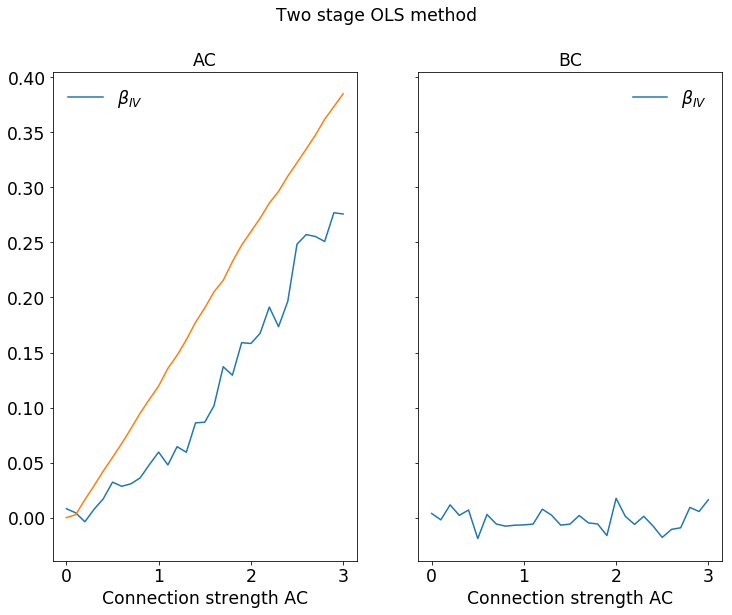

In [109]:
fig, (axa, axb) = plt.subplots(1,2, sharey=True)

s = 1

plt.suptitle('Two stage OLS method', fontsize='xx-large')

axa.plot(amps, s * results['beta_AC'], label=r'$\beta_{IV}$')
axa.plot(amps, results['rate_C'] / results['rate_A'][0] - results['rate_C'][0] / results['rate_A'][0])
# axa.plot(amps, s * results['beta_AC_shift'], label=r'$\beta_{IV}$ shifted')
# axa.plot(amps, s * results['beta_AC'] - s * results['beta_AC_shift'], label=r'$\beta_{IV}$ corrected')
# axa.plot(amps, results['rate_C'] - results['rate_C'][0], label='AC induced rate')
axa.legend(frameon=False, loc=0)
axa.set_xlabel('Connection strength AC')
axa.set_title('AC')

axb.plot(amps, s * results['beta_BC'], label=r'$\beta_{IV}$')
# axb.plot(amps, s * results['beta_BC_shift'], label=r'$\beta_{IV}$ shifted')
# axb.plot(amps, s * results['beta_BC'] - s * results['beta_BC_shift'], label=r'$\beta_{IV}$ corrected')
# axb.plot(amps, np.zeros_like(amps), label='BC induced rate')
axb.legend(frameon=False, loc=0)
axb.set_xlabel('Connection strength AC')
axb.set_title('BC')

# error(t)

In [7]:
# data = simulate(par, stop_time=2000, J_AC=2.0, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)

stop_time = data['status']['time'] / 1000
stim_times = data['epoch']['times'] / 1000
A_spikes, B_spikes, C_spikes = [s['times'] / 1000 for s in data['spiketrains']]

simulating  1999939.5
stimulating  31475
connecting  J_AC 2.0


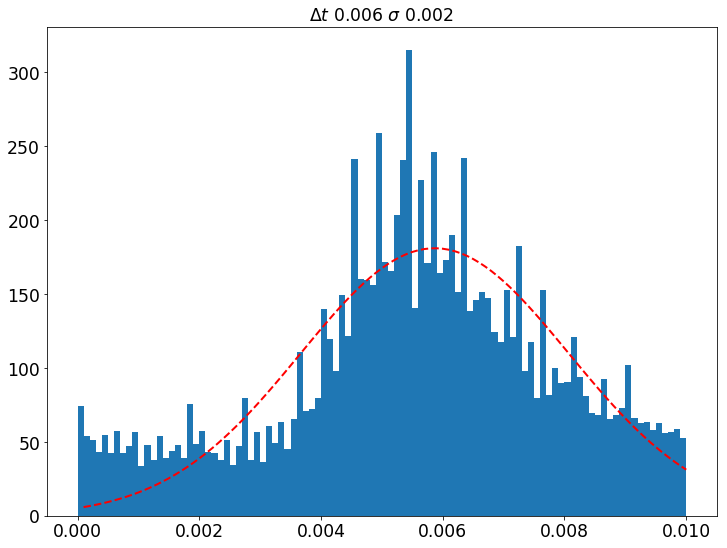

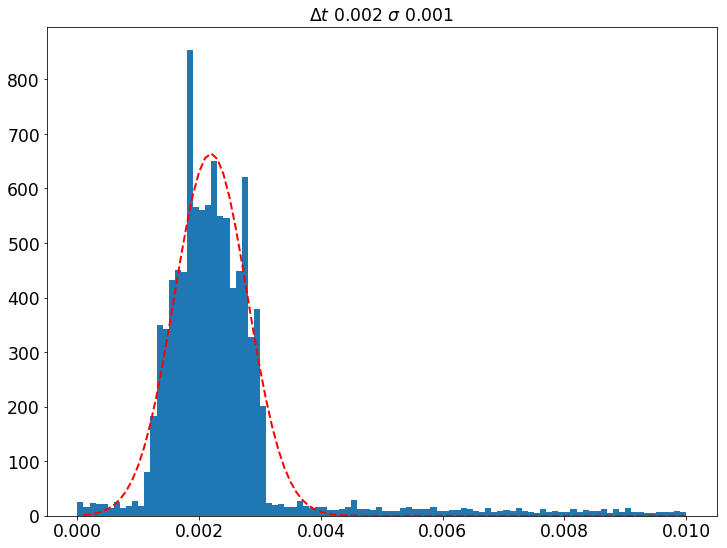

In [8]:
delta_t_C, sigma_C = fit_latency(stim_times, C_spikes, limit=[0, 10e-3], plot=True)
plt.figure()
delta_t_A, sigma_A = fit_latency(stim_times, A_spikes, limit=[0, 10e-3], plot=True)

In [9]:
stop_time

1999.9695

HBox(children=(IntProgress(value=0, max=19), HTML(value='')))

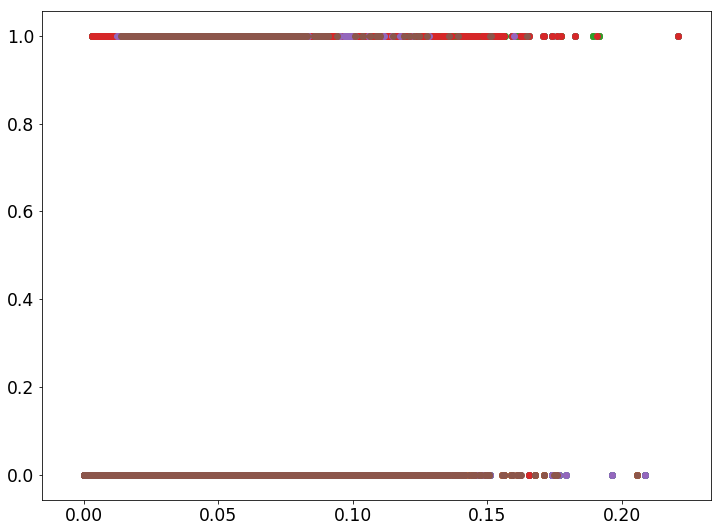

In [59]:
latency = 4e-3
winsize = 4e-3

time_shift = 15e-3

results_t = defaultdict(list)
times = np.arange(100, stop_time, 100)

for t in tqdm(times):
    mask_A = (A_spikes < t)
    mask_B = (B_spikes < t)
    mask_C = (C_spikes < t)
    mask_S = (stim_times < t)
    
    beta_AC = IV(A_spikes[mask_A], C_spikes[mask_C], stim_times[mask_S], latency, winsize)
    beta_BC = IV(B_spikes[mask_B], C_spikes[mask_C], stim_times[mask_S], latency, winsize)
    
    beta_ACr = IV(A_spikes[mask_A], C_spikes[mask_C], stim_times[mask_S] - time_shift, latency, winsize)
    beta_BCr = IV(B_spikes[mask_B], C_spikes[mask_C], stim_times[mask_S] - time_shift, latency, winsize)
    
    
    results_t['beta_AC'].append(beta_AC)
    results_t['beta_BC'].append(beta_BC)    
    results_t['beta_AC_shift'].append(beta_ACr)    
    results_t['beta_BC_shift'].append(beta_BCr)
    results_t['rate_A'].append(sum(mask_A) / t)
    results_t['rate_B'].append(sum(mask_B) / t)
    results_t['rate_C'].append(sum(mask_C) / t)
    results_t['rate_S'].append(sum(mask_S) / t)
    
results_t = {k: np.array(v) for k, v in results_t.items()}

In [60]:
(len(C_spikes) / stop_time - results['rate_C'][0]) / (len(A_spikes) / stop_time)

NameError: name 'results' is not defined

In [ ]:
len(C_spikes) / stop_time, results['rate_C'][0]

In [ ]:
len(stim_times) / stop_time

In [ ]:
len(C_spikes) / len(stim_times)

In [ ]:
0.2 * len(stim_times) / stop_time

Text(0.5,1,'BC')

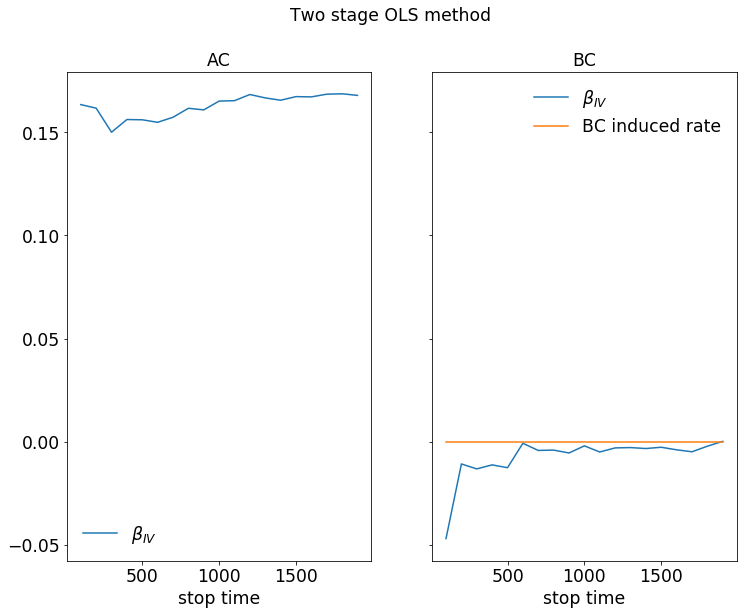

In [61]:
fig, (axa, axb) = plt.subplots(1,2, sharey=True)

s = 1

plt.suptitle('Two stage OLS method', fontsize='xx-large')

axa.plot(times, s * results_t['beta_AC'], label=r'$\beta_{IV}$')
# axa.plot(times, results_t['rate_C'] / results_t['rate_A'] - results['rate_C'][0] / results['rate_A'][0])
# axa.plot(times, s * results_t['beta_AC_shift'], label=r'$\beta_{IV}$ shifted')
# axa.plot(times, s * results_t['beta_AC'] - s * results_t['beta_AC_shift'], label=r'$\beta_{IV}$ corrected')
# axa.plot(times, results_t['rate_C'] - results_t['rate_C'][0], label='AC induced rate')
axa.legend(frameon=False, loc=0)
axa.set_xlabel('stop time')
axa.set_title('AC')

axb.plot(times, s * results_t['beta_BC'], label=r'$\beta_{IV}$')
# axb.plot(times, s * results_t['beta_BC_shift'], label=r'$\beta_{IV}$ shifted')
# axb.plot(times, s * results_t['beta_BC'] - s * results_t['beta_BC_shift'], label=r'$\beta_{IV}$ corrected')
axb.plot(times, np.zeros_like(times), label='BC induced rate')
axb.legend(frameon=False, loc=0)
axb.set_xlabel('stop time')
axb.set_title('BC')